## Requirement Installation

In [1]:
!pip install transformers[torch] datasets -q

## Import Libraries

In [2]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

2024-05-04 13:16:58.927688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 13:16:58.927782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 13:16:59.069461: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dataset_path = 'flaviagiammarino/vqa-rad'

dataset = load_dataset(dataset_path)

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

## Sample Visualization

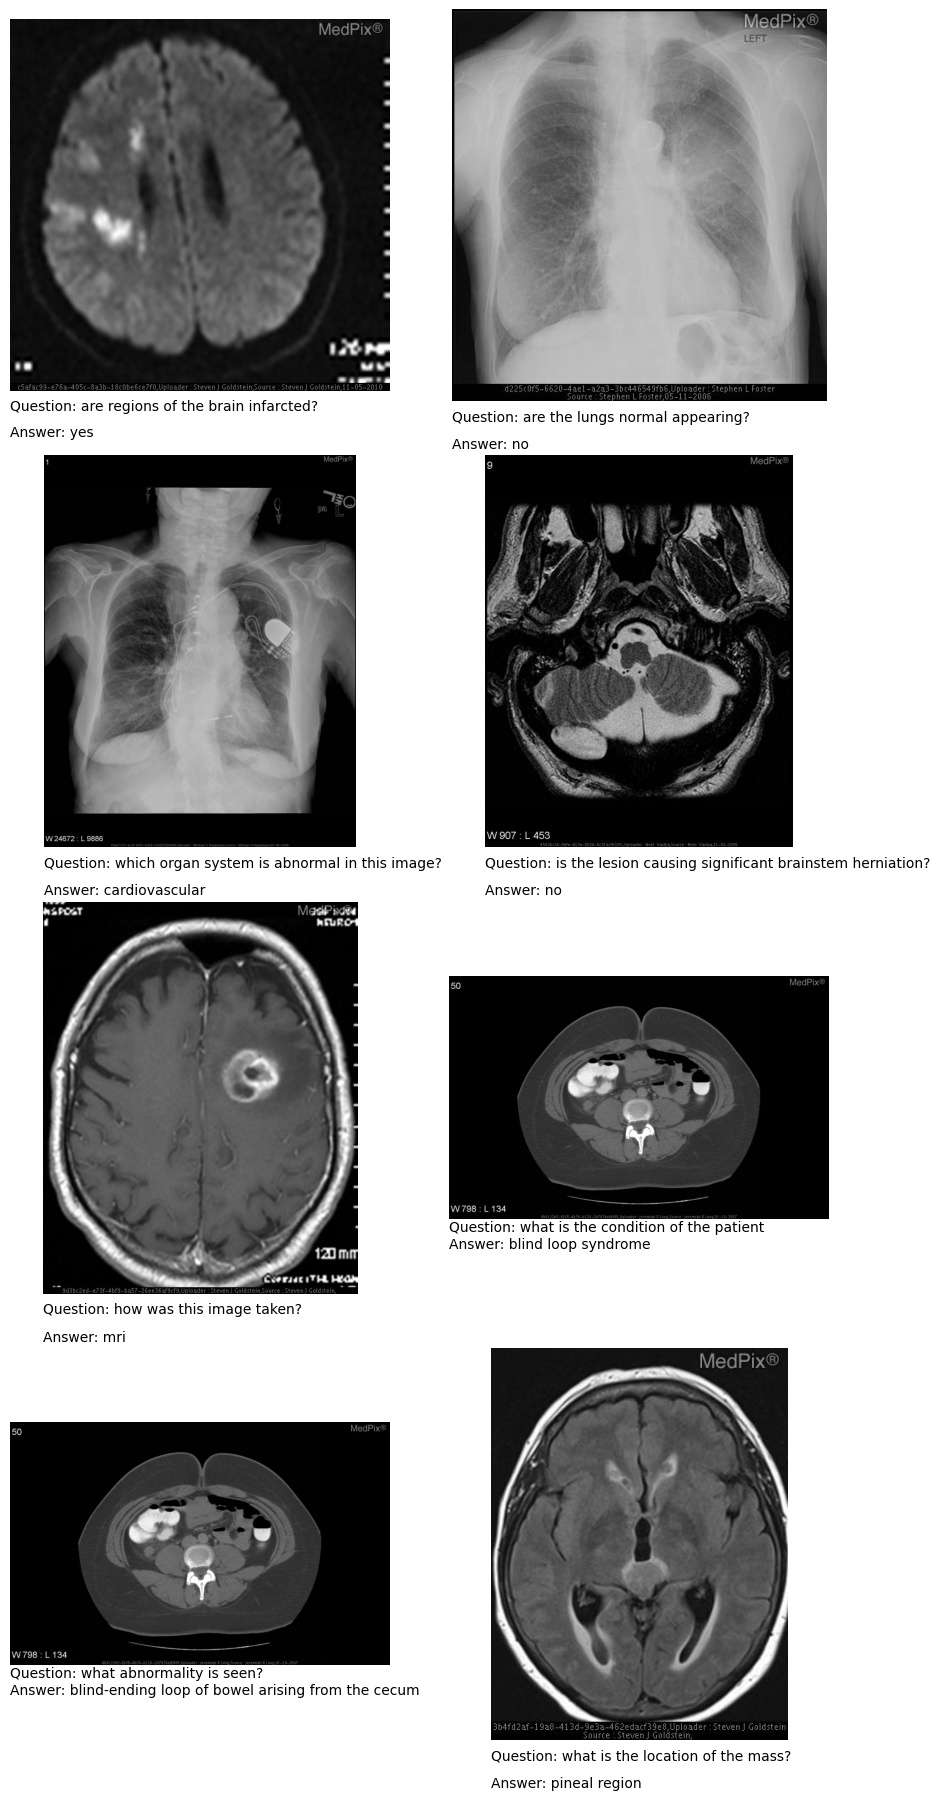

In [5]:
num_rows = 4
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 18))

# Vẽ hình ảnh
for i, ax in enumerate(axes.flat):
    sample = dataset['train'][i]
    PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')

    ax.imshow(PIL_image)
    ax.axis('off')

# In ra câu hỏi và câu trả lời
for i, ax in enumerate(axes.flat):
    sample = dataset['train'][i]

    question = sample['question']
    answer = sample['answer']

    ax.text(0, -0.05, f"Question: {question}", transform=ax.transAxes, fontsize=10, ha='left')
    ax.text(0, -0.12, f"Answer: {answer}", transform=ax.transAxes, fontsize=10, ha='left')

plt.tight_layout()
plt.show()


In [6]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

In [7]:
train_data = dataset['train']
test_data = dataset['test']

print(train_data)
print(test_data)

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 1793
})
Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 451
})


## Build Data-loader

In [8]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding

In [9]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [10]:
train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

test_vqa_dataset = VQADataset(data=test_data,
                     segment='test',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

In [12]:
train_vqa_dataset[0]

{'input_ids': tensor([  101,  2024,  4655,  1997,  1996,  4167,  1999, 14971, 10985,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-1.6463, -1.6317, -1.6171,  ..., -1.7193, -1.6463, -1.5733],
         [-1.6317, -1.6025, -1.5879,  ..., -1.6171, -1.5879, -1.5733],
         [-1.6025, -1.6025, -1.5879,  ..., -1.3251, -1.5733, -1.5295],
         ...,
         [-1.7339, -1.7339, -1.7193,  ..., -1.5003, -1.0477, -0.8580],
         [-1.7777, -1.7923, -1.5149,  ..., -1.4127, -1.7923, -1.7923],
         [-1.7777, -1.7777, -1.5733,  ..., -1.5733, -1.7777, -1.7777]],

        [[-1.6020, -1.5870, -1.5720,  ..., -1.6771, -1.6020, -1.5270],
         [-1.5870, -1.5570, -1.5420,  ..., -1.5720, -1.5420, -1.527

In [11]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=56,
                              shuffle=False)
test_dataloader = DataLoader(test_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=56,
                            shuffle=False)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([56, 32])
attention_mask torch.Size([56, 32])
pixel_values torch.Size([56, 3, 128, 128])
labels torch.Size([56, 32])


## Build Model

In [13]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
model.to(device)

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] are the lungs normal appearing? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] no [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


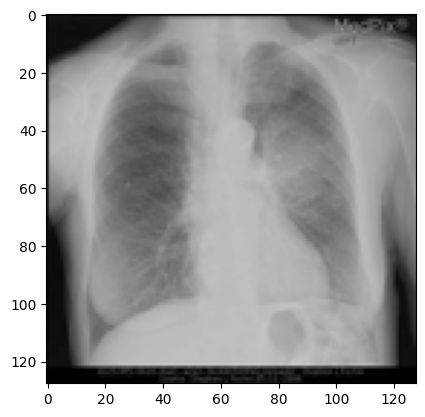

In [17]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

## Model Training

In [15]:
def accuracy_score_hari():
  res = []
  num_rows = dataset['test'].num_rows
  for x in range(num_rows-1):
      sample = test_vqa_dataset[x]
      sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}
      outputs = model.generate(pixel_values=sample['pixel_values'],
                              input_ids=sample['input_ids'])
      pre = text_processor.decode(outputs[0],skip_special_tokens=True)
      act = text_processor.decode(sample['labels'][0], skip_special_tokens=True)
      # print(pre)
      # print(act)

      pre_arr = []
      act_arr = []

      pre_arr = pre.split(" ")
      # print(pre_arr)
      act_arr = act.split(" ")
      count = 0
      for i in pre_arr:
        if i in act_arr:
          count += 1
      res.append(count/len(act_arr))

  # print("res",res)
  return res
print("accuracy_score")
# accuracy_score_hari()

accuracy_score


In [16]:
model.train()
for epoch in range(35):
    print(f"Epoch: {epoch+1}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    c_p = accuracy_score_hari()
    print("accuracy: ", sum(c_p)/len(c_p))
    print("Loss:", sum(total_loss))
    print("total loss: ", total_loss)

Epoch: 1


  0%|          | 0/33 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


accuracy:  0.3101111111111111
Loss: 152.6216998398304
total loss:  [10.446934700012207, 10.275491714477539, 10.133038520812988, 9.807023048400879, 9.35242748260498, 8.728776931762695, 8.194845199584961, 7.810068130493164, 7.457539081573486, 7.33386754989624, 6.7677531242370605, 6.290046215057373, 5.983461856842041, 5.7366414070129395, 5.472086429595947, 4.858771800994873, 4.19677209854126, 3.7280032634735107, 3.2310707569122314, 2.765564203262329, 2.3919172286987305, 2.0210816860198975, 1.7682390213012695, 1.4003944396972656, 1.326380729675293, 1.1378766298294067, 0.911769449710846, 1.0112168788909912, 0.4926029443740845, 0.6237674951553345, 0.3147803544998169, 0.49772316217422485, 0.15376630425453186]
Epoch: 2


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.26222222222222225
Loss: 14.920728022232652
total loss:  [0.5514009594917297, 0.42622947692871094, 0.590594470500946, 0.35898706316947937, 0.19720318913459778, 0.3070317208766937, 0.2016277015209198, 0.42210307717323303, 0.35900846123695374, 1.1389803886413574, 0.6809663772583008, 0.5283719301223755, 0.6878420114517212, 0.8965583443641663, 1.0379449129104614, 0.7201769351959229, 0.4493125081062317, 0.3497089445590973, 0.28995296359062195, 0.2218807190656662, 0.24115672707557678, 0.2700280547142029, 0.3628426790237427, 0.3005557656288147, 0.49627190828323364, 0.4992642104625702, 0.4452616274356842, 0.6367042660713196, 0.2743360698223114, 0.40971124172210693, 0.19946691393852234, 0.34806984663009644, 0.02117655612528324]
Epoch: 3


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3074074074074074
Loss: 13.518206087872386
total loss:  [0.45982107520103455, 0.34462523460388184, 0.48678821325302124, 0.2971359193325043, 0.16229520738124847, 0.25418469309806824, 0.17087414860725403, 0.3784680664539337, 0.3296353816986084, 0.9619680643081665, 0.5874751210212708, 0.457148015499115, 0.598107635974884, 0.8895419836044312, 0.9644681811332703, 0.6517630219459534, 0.39836400747299194, 0.30311453342437744, 0.2614981532096863, 0.1961178183555603, 0.2096775472164154, 0.2444506585597992, 0.3697221875190735, 0.28148898482322693, 0.45107147097587585, 0.4731922149658203, 0.440975159406662, 0.6667287945747375, 0.24822604656219482, 0.4178047478199005, 0.19671472907066345, 0.33543139696121216, 0.029327673837542534]
Epoch: 4


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.27944444444444444
Loss: 12.713321164250374
total loss:  [0.4423006772994995, 0.3242781460285187, 0.45667773485183716, 0.2871555685997009, 0.16682875156402588, 0.24438926577568054, 0.16040168702602386, 0.357445627450943, 0.31025025248527527, 0.8927116394042969, 0.5784773826599121, 0.45181405544281006, 0.5898882150650024, 0.7865240573883057, 0.9008966684341431, 0.6468554139137268, 0.39858478307724, 0.31542500853538513, 0.25035470724105835, 0.19000615179538727, 0.2171141654253006, 0.2608490288257599, 0.33016499876976013, 0.2716033458709717, 0.4180883467197418, 0.4465634524822235, 0.39570459723472595, 0.5420007109642029, 0.22442293167114258, 0.36239540576934814, 0.16435298323631287, 0.2999650537967682, 0.028830349445343018]
Epoch: 5


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3168765432098765
Loss: 11.637226330116391
total loss:  [0.39220330119132996, 0.2889995574951172, 0.4058428406715393, 0.28075912594795227, 0.15662480890750885, 0.22651904821395874, 0.15197986364364624, 0.3309966027736664, 0.2857138216495514, 0.8346787691116333, 0.5180402398109436, 0.4389481842517853, 0.5790400505065918, 0.7343847155570984, 0.8005913496017456, 0.5772902369499207, 0.3507631719112396, 0.27902892231941223, 0.22681307792663574, 0.17361432313919067, 0.18966996669769287, 0.22885407507419586, 0.2901598811149597, 0.24203179776668549, 0.3905472755432129, 0.3978766202926636, 0.36551544070243835, 0.49818602204322815, 0.21608169376850128, 0.3356783092021942, 0.1559291034936905, 0.26915064454078674, 0.024713488295674324]
Epoch: 6


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.27985185185185185
Loss: 10.133979415521026
total loss:  [0.3594898283481598, 0.2668594717979431, 0.36711105704307556, 0.24192063510417938, 0.13708336651325226, 0.1972200572490692, 0.12800654768943787, 0.29687172174453735, 0.2545531690120697, 0.673808217048645, 0.43492746353149414, 0.38351404666900635, 0.4932292699813843, 0.6447142958641052, 0.7263193726539612, 0.5228818655014038, 0.30902594327926636, 0.24030481278896332, 0.21402601897716522, 0.15819957852363586, 0.16382579505443573, 0.2203081250190735, 0.23732034862041473, 0.22138863801956177, 0.3469361662864685, 0.3458249866962433, 0.28885239362716675, 0.42816707491874695, 0.15909752249717712, 0.2757503390312195, 0.13473355770111084, 0.238782599568367, 0.022925129160284996]
Epoch: 7


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2982037037037037
Loss: 8.105062888935208
total loss:  [0.3333739936351776, 0.23388665914535522, 0.29143980145454407, 0.18460769951343536, 0.11446933448314667, 0.15403634309768677, 0.11208783835172653, 0.24977369606494904, 0.204208105802536, 0.457343727350235, 0.3207489252090454, 0.318280965089798, 0.3723534345626831, 0.5273090600967407, 0.5333009958267212, 0.3717598021030426, 0.25573405623435974, 0.21062108874320984, 0.18792851269245148, 0.12697279453277588, 0.13310685753822327, 0.16399213671684265, 0.20564408600330353, 0.18441632390022278, 0.3175097703933716, 0.2626495659351349, 0.21991367638111115, 0.32508912682533264, 0.12739616632461548, 0.24714301526546478, 0.1251545250415802, 0.20567038655281067, 0.0271404180675745]
Epoch: 8


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.33344444444444454
Loss: 6.646084742620587
total loss:  [0.2904389500617981, 0.1847134828567505, 0.2393561750650406, 0.16734904050827026, 0.10129562020301819, 0.12517091631889343, 0.09684229642152786, 0.21356984972953796, 0.15583612024784088, 0.37499043345451355, 0.2616792619228363, 0.2536889612674713, 0.2973293960094452, 0.4251733124256134, 0.3802746534347534, 0.2716417908668518, 0.1994418352842331, 0.1719643771648407, 0.15453220903873444, 0.1102844774723053, 0.11815579980611801, 0.13179922103881836, 0.1741059422492981, 0.162623792886734, 0.2692505121231079, 0.20518963038921356, 0.19225381314754486, 0.2728332281112671, 0.12002111971378326, 0.1940615326166153, 0.11201152950525284, 0.19580094516277313, 0.022404516115784645]
Epoch: 9


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2964363722697056
Loss: 5.743268983438611
total loss:  [0.23102612793445587, 0.15284974873065948, 0.19841758906841278, 0.15521126985549927, 0.10020428150892258, 0.11343985795974731, 0.08654745668172836, 0.17632943391799927, 0.13756078481674194, 0.31191393733024597, 0.2412375658750534, 0.22153139114379883, 0.2783876657485962, 0.3791303038597107, 0.3131447732448578, 0.23198361694812775, 0.16201794147491455, 0.1520185023546219, 0.13327647745609283, 0.10067672282457352, 0.11708880960941315, 0.10876963287591934, 0.15933409333229065, 0.12082043290138245, 0.21755261719226837, 0.18194755911827087, 0.16805319488048553, 0.21098823845386505, 0.10474693030118942, 0.16197901964187622, 0.1068083643913269, 0.1863352209329605, 0.021939421072602272]
Epoch: 10


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.31020784154117487
Loss: 5.075509799644351
total loss:  [0.2091989368200302, 0.1410963535308838, 0.19100552797317505, 0.1472812443971634, 0.08369690179824829, 0.10296963155269623, 0.08003514260053635, 0.15699507296085358, 0.12792280316352844, 0.24212278425693512, 0.21133756637573242, 0.19967500865459442, 0.23312142491340637, 0.3227927088737488, 0.26671814918518066, 0.17663876712322235, 0.15469560027122498, 0.14845451712608337, 0.12853369116783142, 0.09058990329504013, 0.1086617037653923, 0.10019940137863159, 0.14829587936401367, 0.1198483482003212, 0.1847340315580368, 0.15261626243591309, 0.14911748468875885, 0.17780792713165283, 0.09828762710094452, 0.1574033498764038, 0.08835753798484802, 0.15480227768421173, 0.02049623243510723]
Epoch: 11


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3057407407407407
Loss: 4.651322120800614
total loss:  [0.19045421481132507, 0.14328327775001526, 0.1651965230703354, 0.13688763976097107, 0.08230245113372803, 0.09365620464086533, 0.07395315170288086, 0.13382215797901154, 0.11825306713581085, 0.21635375916957855, 0.19960685074329376, 0.18098962306976318, 0.2061239331960678, 0.2849932610988617, 0.22720326483249664, 0.17321692407131195, 0.14325103163719177, 0.12609553337097168, 0.11415541172027588, 0.07712756097316742, 0.09728164225816727, 0.08112607151269913, 0.1315423846244812, 0.1109350174665451, 0.1777445524930954, 0.15148897469043732, 0.15820838510990143, 0.17401647567749023, 0.09883919358253479, 0.12553048133850098, 0.08938945084810257, 0.1481710970401764, 0.020122552290558815]
Epoch: 12


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.30462962962962964
Loss: 4.140027806162834
total loss:  [0.1710384488105774, 0.12317157536745071, 0.1458650529384613, 0.11937806755304337, 0.08020826429128647, 0.08667627722024918, 0.0739382728934288, 0.1224878653883934, 0.10530804842710495, 0.17469625174999237, 0.17972204089164734, 0.1498384028673172, 0.21911904215812683, 0.24878820776939392, 0.20594751834869385, 0.1578778773546219, 0.12543487548828125, 0.12213724851608276, 0.1158524677157402, 0.0737522765994072, 0.08937836438417435, 0.069449283182621, 0.11350101977586746, 0.09772282093763351, 0.1488054394721985, 0.1298525631427765, 0.11893072724342346, 0.1523245871067047, 0.08191763609647751, 0.10193139314651489, 0.0822359174489975, 0.13355489075183868, 0.019185081124305725]
Epoch: 13


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.32211992945326284
Loss: 3.7214506324380636
total loss:  [0.15500712394714355, 0.10781010240316391, 0.12867949903011322, 0.1018182635307312, 0.07166945934295654, 0.07308783382177353, 0.07001593708992004, 0.11410479247570038, 0.09805693477392197, 0.17465965449810028, 0.15260499715805054, 0.1312124878168106, 0.16172033548355103, 0.23125916719436646, 0.1764288991689682, 0.14016541838645935, 0.1105256974697113, 0.11298035830259323, 0.09754215180873871, 0.06756462901830673, 0.08165955543518066, 0.050739143043756485, 0.10393471270799637, 0.09344206750392914, 0.12781649827957153, 0.1383429914712906, 0.12136413902044296, 0.13959231972694397, 0.0812237411737442, 0.10210470855236053, 0.0749351978302002, 0.10930237919092178, 0.020079435780644417]
Epoch: 14


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2785185185185185
Loss: 3.551026836037636
total loss:  [0.1319257915019989, 0.11340152472257614, 0.12150100618600845, 0.10211552679538727, 0.0693998858332634, 0.06969914585351944, 0.06510187685489655, 0.10000202804803848, 0.09560272097587585, 0.15665224194526672, 0.147531196475029, 0.12469932436943054, 0.13819044828414917, 0.19746176898479462, 0.15140964090824127, 0.1267634779214859, 0.11039052158594131, 0.11247767508029938, 0.09785348176956177, 0.062316421419382095, 0.08671149611473083, 0.05286835879087448, 0.11338575184345245, 0.08640260994434357, 0.1277785450220108, 0.1272183209657669, 0.12890605628490448, 0.1311900019645691, 0.10689235478639603, 0.09391326457262039, 0.07197649031877518, 0.10544777661561966, 0.023840103298425674]
Epoch: 15


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2894449192782526
Loss: 3.386618049815297
total loss:  [0.13612721860408783, 0.10370059311389923, 0.12596924602985382, 0.11913832277059555, 0.07055947184562683, 0.06610988080501556, 0.06580813974142075, 0.10664861649274826, 0.10713256150484085, 0.15356962382793427, 0.14636337757110596, 0.11334303021430969, 0.128953754901886, 0.18174146115779877, 0.16292241215705872, 0.12137546390295029, 0.09632968157529831, 0.09816275537014008, 0.09487976878881454, 0.06231983006000519, 0.08262564986944199, 0.0434412881731987, 0.09720230102539062, 0.08359421789646149, 0.11351219564676285, 0.11685171723365784, 0.10410512238740921, 0.11773049831390381, 0.07699180394411087, 0.09504210203886032, 0.07985575497150421, 0.0973280817270279, 0.017182106152176857]
Epoch: 16


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2601851851851852
Loss: 3.185816252604127
total loss:  [0.11914706230163574, 0.10833624750375748, 0.11192537844181061, 0.10026620328426361, 0.05922062695026398, 0.07688183337450027, 0.05968859791755676, 0.09131426364183426, 0.07923474162817001, 0.12439887970685959, 0.1397307813167572, 0.11019632965326309, 0.12551258504390717, 0.1780032217502594, 0.15290895104408264, 0.11543294787406921, 0.09407126903533936, 0.10835667699575424, 0.08343084901571274, 0.05997816100716591, 0.07972842454910278, 0.041180141270160675, 0.10127768665552139, 0.08861926198005676, 0.11350511014461517, 0.11038315296173096, 0.10304833203554153, 0.11272569000720978, 0.07529690116643906, 0.0761193111538887, 0.06961502879858017, 0.09595714509487152, 0.020324459299445152]
Epoch: 17


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.29656172839506173
Loss: 2.9451228100806475
total loss:  [0.11649967730045319, 0.09270046651363373, 0.09020868688821793, 0.08741433918476105, 0.06292306631803513, 0.05931666120886803, 0.05873170495033264, 0.0943201333284378, 0.08152133226394653, 0.12154823541641235, 0.13750366866588593, 0.09089207649230957, 0.11209114640951157, 0.15587016940116882, 0.1327248215675354, 0.10854021459817886, 0.09108294546604156, 0.10586325824260712, 0.08565577864646912, 0.055782608687877655, 0.07745126634836197, 0.04690318554639816, 0.08917734026908875, 0.07674330472946167, 0.10229138284921646, 0.09592639654874802, 0.0982101783156395, 0.08788381516933441, 0.06848901510238647, 0.07463019341230392, 0.07670915126800537, 0.09155979007482529, 0.017956798896193504]
Epoch: 18


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2963950617283951
Loss: 2.841640306636691
total loss:  [0.11060787737369537, 0.09130013734102249, 0.08793041855096817, 0.07677798718214035, 0.05967053025960922, 0.05697121098637581, 0.05047324672341347, 0.08657196164131165, 0.07310646027326584, 0.12052476406097412, 0.11859402805566788, 0.0953344851732254, 0.11091135442256927, 0.15650659799575806, 0.11766930669546127, 0.10321779549121857, 0.08756015449762344, 0.08766474574804306, 0.08003617078065872, 0.05269195884466171, 0.07223844528198242, 0.04134166240692139, 0.09319336712360382, 0.07092186063528061, 0.08945979923009872, 0.10747063159942627, 0.10380250960588455, 0.12353147566318512, 0.07044941931962967, 0.0713384672999382, 0.06788502633571625, 0.09012546390295029, 0.015760986134409904]
Epoch: 19


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2964430199430199
Loss: 2.8084420952945948
total loss:  [0.10510116815567017, 0.08621246367692947, 0.10207188874483109, 0.07476489245891571, 0.0676698312163353, 0.05536307767033577, 0.054552532732486725, 0.09261412918567657, 0.08648783713579178, 0.1164306104183197, 0.11013667285442352, 0.09200403839349747, 0.1129249855875969, 0.14609846472740173, 0.13088448345661163, 0.09286922961473465, 0.08827218413352966, 0.0784379318356514, 0.0808480903506279, 0.06149502843618393, 0.06969524174928665, 0.03872726112604141, 0.08863992244005203, 0.07068640738725662, 0.09843779355287552, 0.08842910081148148, 0.09859877824783325, 0.09721339493989944, 0.07147291302680969, 0.07542654871940613, 0.06473804265260696, 0.09249040484428406, 0.01864674501121044]
Epoch: 20


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3185259123592457
Loss: 2.6200196240097284
total loss:  [0.09200101345777512, 0.08268243074417114, 0.08885359764099121, 0.07210925966501236, 0.054635923355817795, 0.05264816805720329, 0.047063976526260376, 0.07996436208486557, 0.07053359597921371, 0.11096954345703125, 0.10566441714763641, 0.09122636169195175, 0.09699380397796631, 0.1408786028623581, 0.12363109737634659, 0.09616490453481674, 0.0772780105471611, 0.07794570922851562, 0.07351130992174149, 0.04910343885421753, 0.06302880495786667, 0.048307813704013824, 0.0772586390376091, 0.06746084243059158, 0.0891483873128891, 0.09454312920570374, 0.08685491979122162, 0.09455275535583496, 0.06246069446206093, 0.08017991483211517, 0.0635928362607956, 0.09052985906600952, 0.018241500481963158]
Epoch: 21


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2940356125356126
Loss: 2.5368626043200493
total loss:  [0.08681496232748032, 0.07668057084083557, 0.083765409886837, 0.06577595323324203, 0.052419498562812805, 0.056710924953222275, 0.05112505331635475, 0.07133597880601883, 0.06875550746917725, 0.09958862513303757, 0.10626383125782013, 0.08776488900184631, 0.09011002629995346, 0.1330999881029129, 0.12727676331996918, 0.09293804317712784, 0.07486281543970108, 0.08219952881336212, 0.07726249098777771, 0.05942117050290108, 0.06472168117761612, 0.044936250895261765, 0.07460235804319382, 0.06237088888883591, 0.08181314170360565, 0.08056485652923584, 0.09599149227142334, 0.08627000451087952, 0.060761742293834686, 0.0695466697216034, 0.06179235503077507, 0.08741411566734314, 0.021905016154050827]
Epoch: 22


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.28219400352733687
Loss: 2.49682648666203
total loss:  [0.09432932734489441, 0.0818520039319992, 0.08547735214233398, 0.06936512142419815, 0.05559147521853447, 0.050567325204610825, 0.04905364662408829, 0.07367710769176483, 0.07134786248207092, 0.10074411332607269, 0.09809088706970215, 0.0758247971534729, 0.08922655880451202, 0.13565300405025482, 0.12091587483882904, 0.08708894997835159, 0.08026564121246338, 0.0818123146891594, 0.06226903200149536, 0.048163410276174545, 0.059257980436086655, 0.03776000440120697, 0.07747208327054977, 0.0765673890709877, 0.08060026168823242, 0.09578818082809448, 0.08813013136386871, 0.08175196498632431, 0.06652429699897766, 0.062466640025377274, 0.05424492433667183, 0.08219990879297256, 0.022746914997696877]
Epoch: 23


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.25171252204585537
Loss: 2.351393244229257
total loss:  [0.08400382101535797, 0.07152991741895676, 0.07476037740707397, 0.06336311995983124, 0.06355199962854385, 0.056177183985710144, 0.04900795593857765, 0.06686665862798691, 0.06758683174848557, 0.0987430065870285, 0.09583336859941483, 0.07869831472635269, 0.08150726556777954, 0.1162051260471344, 0.09611867368221283, 0.07384531199932098, 0.07422629743814468, 0.07369174808263779, 0.06795290857553482, 0.04717113450169563, 0.06543002277612686, 0.03215724602341652, 0.07948654890060425, 0.0704832449555397, 0.08563436567783356, 0.07749232649803162, 0.08630874007940292, 0.07803719490766525, 0.059438109397888184, 0.06602340191602707, 0.06437993794679642, 0.07154981791973114, 0.014131265692412853]
Epoch: 24


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3145432098765432
Loss: 2.2254790235310793
total loss:  [0.07449086010456085, 0.062425367534160614, 0.0689593255519867, 0.08159944415092468, 0.060591597110033035, 0.054162755608558655, 0.0424463115632534, 0.060171909630298615, 0.06519100815057755, 0.08604002743959427, 0.08994190394878387, 0.07360593974590302, 0.08710303157567978, 0.10538627952337265, 0.10786521434783936, 0.07219493389129639, 0.0672067254781723, 0.06773669272661209, 0.066433385014534, 0.04756227880716324, 0.05749036371707916, 0.04109979793429375, 0.07064826041460037, 0.06480948626995087, 0.06663928180932999, 0.07413063943386078, 0.08519524335861206, 0.06275154650211334, 0.05459129437804222, 0.061036575585603714, 0.056988075375556946, 0.07235803455114365, 0.016625432297587395]
Epoch: 25


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2866878306878307
Loss: 2.1940257381647825
total loss:  [0.07830114662647247, 0.06841760128736496, 0.07331401854753494, 0.06121274456381798, 0.051920969039201736, 0.04657336324453354, 0.04695114865899086, 0.07501693814992905, 0.058231204748153687, 0.07344237715005875, 0.08978404104709625, 0.06319271773099899, 0.0751272439956665, 0.12800034880638123, 0.08958134800195694, 0.0719112902879715, 0.0645296573638916, 0.07340384274721146, 0.060296714305877686, 0.04485689476132393, 0.043315716087818146, 0.06682738661766052, 0.0650072768330574, 0.05840638652443886, 0.06721720844507217, 0.07337237149477005, 0.08913254737854004, 0.08821030706167221, 0.048602283000946045, 0.05573086813092232, 0.05423181876540184, 0.07312652468681335, 0.016779432073235512]
Epoch: 26


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3033815628815629
Loss: 2.034383287653327
total loss:  [0.06246685981750488, 0.06827155500650406, 0.06194391846656799, 0.06487103551626205, 0.05146796628832817, 0.047888271510601044, 0.04616157338023186, 0.06572481989860535, 0.053205251693725586, 0.06851983070373535, 0.07573293149471283, 0.0626712515950203, 0.07351617515087128, 0.10541906952857971, 0.07879829406738281, 0.06540072709321976, 0.062309760600328445, 0.07005001604557037, 0.06632538884878159, 0.04651052504777908, 0.04779549688100815, 0.03169645369052887, 0.06024972349405289, 0.05573590472340584, 0.06803423911333084, 0.07339257001876831, 0.0764523595571518, 0.0748332291841507, 0.05015323683619499, 0.05614158511161804, 0.048506010323762894, 0.07458040118217468, 0.019556855782866478]
Epoch: 27


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3022865961199295
Loss: 1.976506458595395
total loss:  [0.06720142811536789, 0.05613645166158676, 0.056141410022974014, 0.05434190481901169, 0.04684269055724144, 0.04851219803094864, 0.041378699243068695, 0.07595092803239822, 0.060432467609643936, 0.05638379603624344, 0.08226713538169861, 0.05694457143545151, 0.06276199966669083, 0.0994129329919815, 0.07485136389732361, 0.06263545155525208, 0.056363172829151154, 0.059036631137132645, 0.05522191897034645, 0.05379975214600563, 0.0482051782310009, 0.030648846179246902, 0.06398777663707733, 0.06257536262273788, 0.06018826365470886, 0.07514289021492004, 0.07689717411994934, 0.0919574424624443, 0.04559049382805824, 0.04751935973763466, 0.048524223268032074, 0.07764067500829697, 0.021011868491768837]
Epoch: 28


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.2971199294532628
Loss: 1.9312116391956806
total loss:  [0.07286949455738068, 0.056038662791252136, 0.0625585988163948, 0.05785800516605377, 0.05082020163536072, 0.04311265051364899, 0.04247698187828064, 0.05063468590378761, 0.052995383739471436, 0.06372524052858353, 0.07478003948926926, 0.06287960708141327, 0.07509766519069672, 0.09454060345888138, 0.08222110569477081, 0.048148781061172485, 0.060497134923934937, 0.06701221317052841, 0.059937983751297, 0.041318558156490326, 0.045933790504932404, 0.025984805077314377, 0.0653938576579094, 0.06194206699728966, 0.08348710834980011, 0.06741826981306076, 0.07492704689502716, 0.06614755839109421, 0.04452354833483696, 0.04567425325512886, 0.047931425273418427, 0.06070256233215332, 0.02162174880504608]
Epoch: 29


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.27822751322751327
Loss: 1.7152561992406845
total loss:  [0.0708729475736618, 0.06214918568730354, 0.05634072795510292, 0.060843031853437424, 0.04587338864803314, 0.042299553751945496, 0.04246269538998604, 0.046505920588970184, 0.04266632720828056, 0.04108163341879845, 0.07376405596733093, 0.04944740980863571, 0.048906996846199036, 0.07253102213144302, 0.06423415243625641, 0.05214374139904976, 0.04824497550725937, 0.07488244026899338, 0.05626644566655159, 0.03879989683628082, 0.04781969636678696, 0.031660959124565125, 0.058797623962163925, 0.05670658499002457, 0.054100729525089264, 0.06422144919633865, 0.054574742913246155, 0.05494055896997452, 0.043696846812963486, 0.043995410203933716, 0.04436905309557915, 0.05457356944680214, 0.015482425689697266]
Epoch: 30


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3033544973544973
Loss: 1.6861614920198917
total loss:  [0.05234440043568611, 0.05919199436903, 0.05298594757914543, 0.04804316163063049, 0.048160407692193985, 0.044820498675107956, 0.04204050078988075, 0.05717578902840614, 0.046729445457458496, 0.03894184157252312, 0.06571625918149948, 0.04830551892518997, 0.05454469472169876, 0.07459688186645508, 0.0599190853536129, 0.04836972802877426, 0.05018629878759384, 0.05991072952747345, 0.05108344554901123, 0.031531430780887604, 0.042909663170576096, 0.028847597539424896, 0.06012827903032303, 0.05479557439684868, 0.06414533406496048, 0.0695333182811737, 0.06799136847257614, 0.04953115060925484, 0.04525065794587135, 0.04865017160773277, 0.04104502499103546, 0.05875515937805176, 0.019980132579803467]
Epoch: 31


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3092469135802469
Loss: 1.7386505883187056
total loss:  [0.05712471902370453, 0.08667673915624619, 0.05877186730504036, 0.04891756922006607, 0.04187732934951782, 0.04715770110487938, 0.04052398353815079, 0.06232515349984169, 0.038775958120822906, 0.042231276631355286, 0.06577251106500626, 0.05201896280050278, 0.0580885075032711, 0.06831897050142288, 0.076424740254879, 0.056977879256010056, 0.050100237131118774, 0.06313398480415344, 0.045901328325271606, 0.04573943838477135, 0.038308657705783844, 0.027951408177614212, 0.05745652690529823, 0.053419508039951324, 0.06402857601642609, 0.06690272688865662, 0.06727074086666107, 0.052111536264419556, 0.047647565603256226, 0.04068489745259285, 0.04623804986476898, 0.05158235505223274, 0.01818918250501156]
Epoch: 32


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3135254375254375
Loss: 1.5687903426587582
total loss:  [0.06361426413059235, 0.04950878769159317, 0.06319541484117508, 0.04416787996888161, 0.04252235218882561, 0.0383932925760746, 0.031155884265899658, 0.05412091687321663, 0.05145914480090141, 0.04174375906586647, 0.05938716605305672, 0.04449180141091347, 0.06193343549966812, 0.07100661844015121, 0.057277120649814606, 0.03764720261096954, 0.036961112171411514, 0.05509451776742935, 0.038398295640945435, 0.03233910724520683, 0.04381723701953888, 0.021614911034703255, 0.044674184173345566, 0.05227630212903023, 0.07057655602693558, 0.05348702892661095, 0.055014628916978836, 0.050300054252147675, 0.03626865893602371, 0.040791306644678116, 0.043952576816082, 0.0603560209274292, 0.02124280296266079]
Epoch: 33


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.29946560846560855
Loss: 1.456623874604702
total loss:  [0.04886150360107422, 0.049010004848241806, 0.05201403796672821, 0.04276696965098381, 0.04201401770114899, 0.03803258761763573, 0.033135950565338135, 0.040607601404190063, 0.03575536608695984, 0.0456232987344265, 0.05629971623420715, 0.04050043970346451, 0.051708661019802094, 0.062432099133729935, 0.0454682782292366, 0.03772454708814621, 0.041349977254867554, 0.04705284535884857, 0.043156154453754425, 0.027623765170574188, 0.03203614056110382, 0.020785896107554436, 0.0558508038520813, 0.046373266726732254, 0.05351198837161064, 0.05543370917439461, 0.05489840731024742, 0.04526995122432709, 0.043613649904727936, 0.047092653810977936, 0.041495431214571, 0.057198673486709595, 0.021925481036305428]
Epoch: 34


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3016666666666667
Loss: 1.3079710360616446
total loss:  [0.04548909142613411, 0.046075839549303055, 0.040450017899274826, 0.03266003355383873, 0.03857986629009247, 0.037569690495729446, 0.03378555551171303, 0.040830984711647034, 0.03492768853902817, 0.03571882098913193, 0.04495842754840851, 0.02909667417407036, 0.04298962652683258, 0.0595981702208519, 0.042829178273677826, 0.03161351755261421, 0.03293805569410324, 0.034402597695589066, 0.03157516196370125, 0.02602747641503811, 0.03812737762928009, 0.017368124797940254, 0.051540832966566086, 0.050984159111976624, 0.04340595006942749, 0.054874762892723083, 0.053149010986089706, 0.047985322773456573, 0.03559771925210953, 0.04036545380949974, 0.03990485519170761, 0.0547226220369339, 0.01782836951315403]
Epoch: 35


  0%|          | 0/33 [00:00<?, ?it/s]

accuracy:  0.3146172839506173
Loss: 1.3319212440401316
total loss:  [0.05109938979148865, 0.05283848196268082, 0.03342273086309433, 0.03249908983707428, 0.03669426217675209, 0.044194139540195465, 0.03198930248618126, 0.0318722166121006, 0.03717867285013199, 0.037372272461652756, 0.04633698612451553, 0.026572486385703087, 0.04960962012410164, 0.06260989606380463, 0.05951874330639839, 0.043962083756923676, 0.03755120933055878, 0.042794790118932724, 0.03629909083247185, 0.02571212127804756, 0.030015403404831886, 0.02697101980447769, 0.040244147181510925, 0.04697536304593086, 0.04303240776062012, 0.04470156878232956, 0.05925006791949272, 0.03927144408226013, 0.044642455875873566, 0.028341008350253105, 0.039413850754499435, 0.05212321877479553, 0.016811702400445938]


In [27]:
import torch
torch.save(model.state_dict(), '/kaggle/working/BLIP.pth')

In [29]:
import torch
from transformers import BlipForQuestionAnswering, BlipProcessor, BlipImageProcessor
from PIL import Image
import numpy as np

# Load the model and processor
model_checkpoint_path = '/kaggle/working/BLIP.pth'  # Specify the path to your checkpoint
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

# Create the model and load the checkpoint
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')  # Use 'cuda' if available

# checkpoint = torch.load(model_checkpoint_path)  # Use 'cuda' if available
# model.load_state_dict(checkpoint['vision_model'])
model.load_state_dict(checkpoint)
# model.eval()

# Function to generate answer for a given image and question
def generate_answer(image_path, question_text):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_encoding = image_processor(image, do_resize=True, size=(128, 128), return_tensors="pt")

    # Tokenize and preprocess the question
    encoding = text_processor(
        None,
        question_text,
        padding="max_length",
        truncation=True,
        max_length=32,
        return_tensors="pt"
    )
    encoding["pixel_values"] = image_encoding["pixel_values"]

    print("inpt_ids",len(encoding["input_ids"]))
    print("pxl",len(encoding["pixel_values"]))
    # Remove batch dimension
#     for k, v in encoding.items():
#         encoding[k] = v.squeeze()
#     print("Question: ",text_processor.decode(encoding['input_ids'], skip_special_tokens=True))
#     sample = {k: v.unsqueeze(0).to(device) for k,v in encoding.items()}

    print("inpt_ids",len(encoding["input_ids"]))
    print("pxl",len(encoding["pixel_values"]))
    # Forward pass to generate answer
    with torch.no_grad():
        outputs = model.generate(input_ids=encoding['input_ids'], pixel_values=image_encoding['pixel_values'])

    # Decode the predicted answer
    predicted_answer = text_processor.decode(outputs[0], skip_special_tokens=True)

    return predicted_answer

# Example usage
image_path = '/kaggle/input/medical/0.jpg'
question_text = 'no of hearts?'
answer = generate_answer(image_path, question_text)
print(f"Question: {question_text}")
print(f"Answer: {answer}")

inpt_ids 1
pxl 1
inpt_ids 1
pxl 1
Question: no of hearts?
Answer: no


## Inference

In [ ]:
# add batch dimension + move to GPU|
for x in range(40):
    sample = test_vqa_dataset[x]
    print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

    # forward pass
    outputs = model.generate(pixel_values=sample['pixel_values'],
                            input_ids=sample['input_ids'])
    print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
    print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
    #########################################################################
    unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    display(Image.fromarray(unnormalized_image))
    #########################################################################
    print("###################################################################")

In [ ]:
idx = 75
sample = test_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))

## Conclusion

A successfully trained and inferred medical Visual Question Answering model has the potential to revolutionize healthcare by enhancing diagnostic accuracy, improving efficiency, and expanding access to medical information. However, careful consideration of ethical, privacy, and regulatory issues is crucial to ensure its safe and responsible use in clinical practice.